# Setup

In [ ]:
import os 
from google.colab import drive
import sys


#need this to load vizdoom module 
system_path = '/content/drive/MyDrive/GitHub/INM363-Project'
drive.mount('/content/drive')
sys.path.append(system_path)

system_path = '/content/drive/MyDrive/GitHub/INM363-Project/src' 
sys.path.append(system_path)

#need this to use gpu on ray 
os.environ['PYTHONPATH'] = '/content/drive/MyDrive/GitHub/INM363-Project' 
os.environ['PYTHONPATH']

Mounted at /content/drive


'/content/drive/MyDrive/GitHub/INM363-Project'

In [ ]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update &> /dev/null


apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip &> /dev/null

# Boost libraries
apt-get install libboost-all-dev &> /dev/null


In [ ]:
!pip install vizdoom --quiet 
!pip install ray  --quiet
!pip install ray['rllib'] --quiet
!pip install Ipython --upgrade --quiet

In [ ]:
from src.vizdoom_gym.envs.VizDoomEnv import VizdoomEnv
from src.vizdoom_gym.envs.VizDoomEnv_def import VizDoomVeryDenseReward
import src.helper_fuctions as helper

In [ ]:
from ray.tune.registry import register_env
import gym
import os
import ray
import ray.rllib.agents.ppo as ppo
from ray.rllib.algorithms.callbacks import RE3UpdateCallbacks
import shutil
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from fnmatch import fnmatch 
import numpy as np
sns.set()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device, "\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

device:  cuda:0 

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Initialize Ray

In [ ]:
ray.shutdown()
print("Shutdown ray")
# start Ray -- add `local_mode=True` here for debugging
ray.init(ignore_reinit_error=True,  num_cpus =2, num_gpus = 1) #local_mode=True,

print("Initialized ray")

# register the custom environment
select_env = "VizDoomVeryDenseReward-v0"

register_env(select_env, lambda config: VizDoomVeryDenseReward())

print("registered environment")

Shutdown ray


2022-09-27 09:57:46,654	INFO worker.py:1518 -- Started a local Ray instance.


Initialized ray
registered environment


# PPO

In [ ]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
config["num_workers"] = 1
config["framework"] = "torch"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['batch_mode'] = 'complete_episodes'

#changing this for evaluation time 
config['explore'] = False 
config['in_evaluation'] = True

ppo_agent = ppo.PPOTrainer(config, env=select_env)

print("created agent")

2022-09-27 09:57:48,749	INFO ppo.py:379 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-09-27 09:57:48,769	INFO algorithm.py:354 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,


(RolloutWorker pid=8670) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=8670) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/new_dense_reward_fixed_start.wad
(RolloutWorker pid=8670) episode timeout: 800
(RolloutWorker pid=8670) screen resolution: 320X240


(RolloutWorker pid=8670) 2022-09-27 09:58:01,535	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-09-27 09:58:12,691	INFO trainable.py:164 -- Trainable.setup took 23.944 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-09-27 09:58:12,695	WARNING util.py:65 -- Install gputil for GPU system monitoring.


created agent


In [ ]:
#create environment 
env = gym.make('VizDoomVeryDenseReward-v0')

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizdoomMyWayHome-v0
  logger.warn(f"Overriding environment {id}")
/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment VizDoomVeryDenseReward-v0
  logger.warn(f"Overriding environment {id}")


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/new_dense_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


In [ ]:

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense" 

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))


ppo_chkpt_mean_rewards = np.array([]) 
ppo_chkpt_std_rewards = np.array([]) 
ppo_chkpt_mean_steps = np.array([]) 
ppo_chkpt_std_steps = np.array([]) 


for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  ppo_agent.restore(chkpt_pth)

  num_episodes = 10
  total_reward = []
  total_steps = [] 
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    eps_steps = 0 
    n_step = 200

    for step in range(n_step):
          action = ppo_agent.compute_action(state)
          state, reward, done, info = env.step(action)
          eps_reward += reward

          #if episode ends early
          if done == 1:
              total_reward.append(eps_reward)
              total_steps.append(step+1)
              state = env.reset()
              break

    #if episode timeout
    if done == 0:
      total_reward.append(eps_reward)
      total_steps.append(n_step)

  #get mean and std over all episodes
  ppo_chkpt_mean_rewards = np.append(ppo_chkpt_mean_rewards, np.mean(total_reward) )
  ppo_chkpt_std_rewards = np.append(ppo_chkpt_std_rewards, np.std(total_reward))
  ppo_chkpt_mean_steps = np.append(ppo_chkpt_mean_steps, np.mean(total_steps))
  ppo_chkpt_std_steps = np.append(ppo_chkpt_std_steps, np.std(total_steps))



In [ ]:
#read first results file 
results_pth = chkpt_root + '/' + 'result_1.csv'
ppo_df_1 = pd.read_csv(results_pth).head(190)
#icm_df_1.tail()
#read second results file 
results_pth = chkpt_root + '/' + 'result.csv'
ppo_df_2 = pd.read_csv(results_pth) 
ppo_df_2['checkpoint'] = ppo_df_2['checkpoint'] 
#icm_df_2
#stack both dataframes 
frames = [ppo_df_1, ppo_df_2]
ppo_df = pd.concat(frames, ignore_index = True)
#cumulative sum of episodes
ppo_df['eps_cumsum'] = ppo_df['episodes_this_iter'].cumsum()
ppo_df = ppo_df[['checkpoint', 'eps_cumsum']]
ppo_df.checkpoint = ppo_df['checkpoint'].astype(int)
ppo_df.tail()

,checkpoint,eps_cumsum
395,396,9436.0
396,397,9459.0
397,398,9483.0
398,399,9517.0
399,400,9542.0


In [ ]:
ppo_cum_eps = [] 
for chkpt in checkpoints:
  chkpt_int = int(chkpt.split('_')[-1])
  eps_num = ppo_df[~(ppo_df['eps_cumsum'].where(ppo_df['checkpoint'] == chkpt_int)).isna()].eps_cumsum.values[0]
  ppo_cum_eps.append(eps_num)


In [ ]:
print(f"Total episodes: {ppo_cum_eps}")
print(f"Mean reward: {ppo_chkpt_mean_rewards}")
print(f"Std reward: {ppo_chkpt_std_rewards}")
print(f"Mean steps: {ppo_chkpt_mean_steps}")
print(f"Std steps: {ppo_chkpt_std_steps}")

#check length of lists are the same 
assert len(ppo_cum_eps) == len(ppo_chkpt_mean_rewards)
assert len(ppo_cum_eps) == len(ppo_chkpt_mean_steps)



Total episodes: [20.0, 221.0, 458.0, 694.0, 931.0, 1160.0, 1387.0, 1617.0, 1867.0, 2117.0, 2349.0, 2589.0, 2826.0, 3068.0, 3305.0, 3544.0, 3777.0, 4019.0, 4260.0, 4490.0, 4724.0, 5204.0, 5676.0, 6154.0, 6626.0, 7096.0, 7597.0, 8091.0, 8568.0, 9055.0, 9542.0]
Mean reward: [0.  0.  2.  2.  0.  0.  0.  0.  0.  0.  2.  2.  2.  2.  0.  2.  2.8 2.1
 2.  0.  0.  3.  0.  3.  0.  0.  2.1 0.6 0.9 0.  0. ]
Std reward: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.4        0.3
 0.         0.         0.         0.         0.         0.
 0.         0.         1.37477271 0.91651514 1.37477271 0.
 0.        ]
Mean steps: [200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200.]
Std steps: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


## PPO avg reward

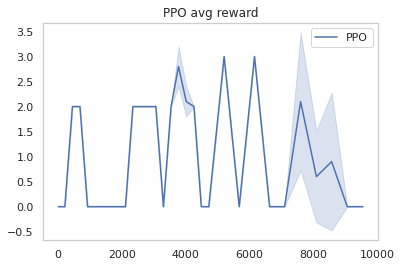

In [ ]:
# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

sns.set_style("whitegrid", {'axes.grid' : False})

plt.plot(ppo_cum_eps, ppo_chkpt_mean_rewards, 'b-', label='PPO')
plt.fill_between(ppo_cum_eps, ppo_chkpt_mean_rewards - ppo_chkpt_std_rewards, ppo_chkpt_mean_rewards + ppo_chkpt_std_rewards, color='b', alpha=0.2) 


plt.legend()
plt.title("PPO avg reward") 
plt.show()


## PPO avg steps

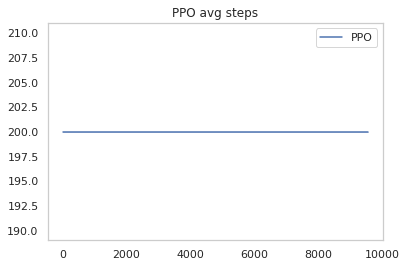

In [ ]:
# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(ppo_cum_eps, ppo_chkpt_mean_steps, 'b-', label='PPO')
plt.fill_between(ppo_cum_eps, (ppo_chkpt_mean_steps - ppo_chkpt_std_steps), (ppo_chkpt_mean_steps + ppo_chkpt_std_steps), color='b', alpha=0.2) 

plt.legend()
plt.title("PPO avg steps") 
plt.show()


## PPO Path

In [ ]:
max_mean_rewards_idx = np.argmax(ppo_chkpt_mean_rewards)
eps_itr = ppo_cum_eps[max_mean_rewards_idx]
print(eps_itr)
best_chkpt = ppo_df[~(ppo_df["eps_cumsum"].where(ppo_df['eps_cumsum'] == eps_itr)).isna()]['checkpoint'].values[0]
print("Best checkpoint: ", best_chkpt)

5204.0
Best checkpoint:  220


In [ ]:
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense" 
chkpt_dir = "checkpoint_000" + str(best_chkpt)
chkpt_pth = chkpt_root + "/" + chkpt_dir
chkpt_pth

'/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense/checkpoint_000220'

In [ ]:
ppo_agent.restore(chkpt_pth)

2022-09-27 11:02:03,754	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/dense/checkpoint_000220
2022-09-27 11:02:03,755	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 220, '_timesteps_total': None, '_time_total': 18005.12664437294, '_episodes_total': 5204}


cumulative reward 0.0
total steps: 199
Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/train/dense_reward_rs.wad
Health Bonus locations: [(-704.0, 96.0), (-544.0, 224.0), (-544.0, -128.0), (-608.0, 96.0), (-544.0, 64.0), (-544.0, 128.0), (-544.0, -32.0), (-544.0, 320.0), (-544.0, 384.0), (-800.0, 96.0), (-896.0, 96.0)]
Armor location: [(-544.0, -192.0)]
Sector locations: [(-672.0, -736.0, 32.0, 32.0), (-736.0, -672.0, 160.0, 160.0), (-608.0, -608.0, 192.0, 256.0), (-480.0, -480.0, 256.0, 192.0), (-672.0, -672.0, -256.0, -64.0), (-416.0, -672.0, -256.0, -256.0), (-416.0, -416.0, -64.0, -256.0), (-672.0, -608.0, -64.0, -64.0), (-480.0, -416.0, -64.0, -64.0), (-672.0, -672.0, 0.0, 32.0), (-416.0, -480.0, 0.0, 0.0), (-672.0, -672.0, 160.0, 192.0), (-608.0, -672.0, 0.0, 0.0), (-416.0, -416.0, 192.0, 0.0), (-672.0, -608.0, 192.0, 192.0), (-480.0, -416.0, 192.0, 1

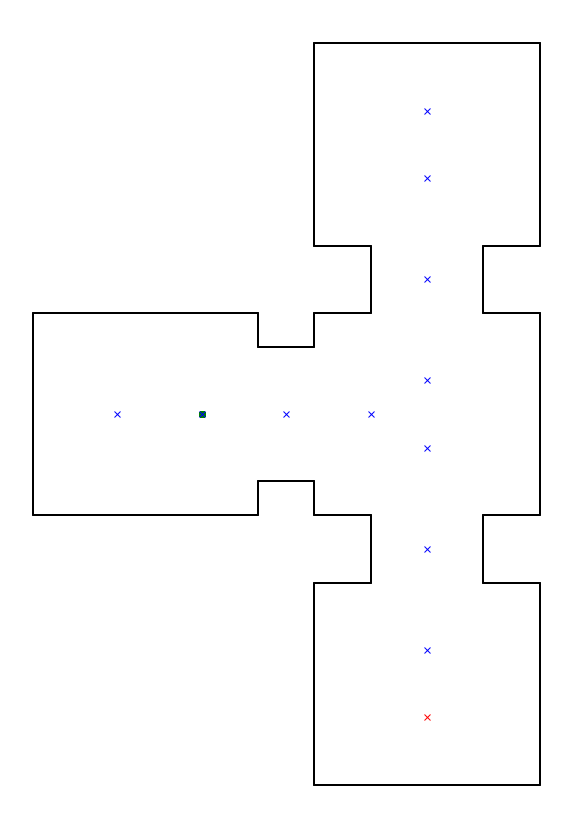

In [ ]:
state = env.reset()
sum_reward = 0
n_step = 200
ppo_path = [] 

for step in range(n_step):
    action = ppo_agent.compute_action(state)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      ppo_path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")

import src.helper_fuctions as helper

sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/train/dense_reward_rs.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, ppo_path)


## PPO Goal Accomplishment

In [ ]:
state = env.reset()

#ppo_path = [] 
num_episodes = 100 
goal_reached = 0 

for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    n_step = 200

    for step in range(n_step):
        action = ppo_agent.compute_action(state)
        state, reward, done, info = env.step(action)
        eps_reward += reward
      
        if done == 1:
          break 

    if eps_reward > 10:
        goal_reached += 1
      
    

print(f"Number of time goal reached: {goal_reached} / {num_episodes}")


Number of time goal reached: 0 / 100


# ICM 

In [ ]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
#config["num_workers"] = 1
config["framework"] = "torch"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['batch_mode'] = 'complete_episodes'

#changing this for evaluation time 
config['explore'] = False
config['in_evaluation'] = True

config["num_workers"] = 0 

config["exploration_config"] = {
    "type": "Curiosity",  # <- Use the Curiosity module for exploring.
    "eta": 0.01, #0.001,  # Weight for intrinsic rewards before being added to extrinsic ones.
    "lr": 0.001,  # Learning rate of the curiosity (ICM) module.
    "feature_dim": 288,  # Dimensionality of the generated feature vectors.
    # Setup of the feature net (used to encode observations into feature (latent) vectors).
    "feature_net_config": {
        "fcnet_hiddens": [],
        "fcnet_activation": "relu",
    },
    "inverse_net_hiddens": [256],  # Hidden layers of the "inverse" model.
    "inverse_net_activation": "relu",  # Activation of the "inverse" model.
    "forward_net_hiddens": [256],  # Hidden layers of the "forward" model.
    "forward_net_activation": "relu",  # Activation of the "forward" model.
    "beta": 0.2,  # Weight for the "forward" loss (beta) over the "inverse" loss (1.0 - beta).
    # Specify, which exploration sub-type to use (usually, the algo's "default"
    # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
   
    "sub_exploration": {
#        "type": "EpsilonGreedy",
#        "initial_epsilon": 1.0, #0.01,
#        "final_epsilon": 0.01, #0.001
        "type": "StochasticSampling",
        
    }
}
config["vf_clip_param"] = 400
icm_agent = ppo.PPOTrainer(config, env=select_env)
print("created agent")

/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/new_dense_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


2022-09-27 10:02:57,826	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-09-27 10:02:58,744	WARNING util.py:65 -- Install gputil for GPU system monitoring.


created agent


In [ ]:
#create environment 
env = gym.make('VizDoomVeryDenseReward-v0')

config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/new_dense_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


In [ ]:

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense" 

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))

#chkpt_mean_rewards = [] 
#chkpt_me

icm_chkpt_mean_rewards = np.array([]) 
icm_chkpt_std_rewards = np.array([]) 
icm_chkpt_mean_steps = np.array([]) 
icm_chkpt_std_steps = np.array([]) 


for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  icm_agent.restore(chkpt_pth)

  num_episodes = 10
  total_reward = []
  total_steps = [] 
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    eps_steps = 0 
    n_step = 200

    for step in range(n_step):
          action = icm_agent.compute_action(state)
          state, reward, done, info = env.step(action)
          eps_reward += reward

          #if episode ends early
          if done == 1:
              total_reward.append(eps_reward)
              total_steps.append(step+1)
              state = env.reset()
              break

    #if episode timeout
    if done == 0:
      total_reward.append(eps_reward)
      total_steps.append(n_step)

  #get mean and std over all episodes
  icm_chkpt_mean_rewards = np.append(icm_chkpt_mean_rewards, np.mean(total_reward) )
  icm_chkpt_std_rewards = np.append(icm_chkpt_std_rewards, np.std(total_reward))
  icm_chkpt_mean_steps = np.append(icm_chkpt_mean_steps, np.mean(total_steps))
  icm_chkpt_std_steps = np.append(icm_chkpt_std_steps, np.std(total_steps))



In [ ]:
#read first results file 
results_pth = chkpt_root + '/' + 'result.csv'
icm_df = pd.read_csv(results_pth) 

#cumulative sum of episodes
icm_df['eps_cumsum'] = icm_df['episodes_this_iter'].cumsum()
icm_df = icm_df[['checkpoint', 'eps_cumsum']]
icm_df.checkpoint = icm_df['checkpoint'].astype(int)
icm_df.tail()

,checkpoint,eps_cumsum
395,396,9214.0
396,397,9234.0
397,398,9254.0
398,399,9275.0
399,400,9296.0


In [ ]:
icm_cum_eps = [] 
for chkpt in checkpoints:
  chkpt_int = int(chkpt.split('_')[-1])
  eps_num = icm_df[~(icm_df['eps_cumsum'].where(icm_df['checkpoint'] == chkpt_int)).isna()].eps_cumsum.values[0]
  icm_cum_eps.append(eps_num)

print(f"Total episodes: {icm_cum_eps}")
print(f"Mean reward: {icm_chkpt_mean_rewards}")
print(f"Std reward: {icm_chkpt_std_rewards}")
print(f"Mean steps: {icm_chkpt_mean_steps}")
print(f"Std steps: {icm_chkpt_std_steps}")

#check length of lists are the same 
assert len(icm_cum_eps) == len(icm_chkpt_mean_rewards)
assert len(icm_cum_eps) == len(icm_chkpt_mean_steps)

Total episodes: [24.0, 120.0, 352.0, 578.0, 803.0, 1041.0, 1282.0, 1514.0, 1637.0, 1759.0, 1877.0, 1995.0, 2111.0, 2226.0, 2342.0, 2575.0, 2815.0, 3047.0, 3300.0, 3543.0, 3793.0, 4038.0, 4286.0, 4532.0, 4775.0, 5240.0, 5715.0, 6178.0, 6633.0, 7087.0, 7547.0, 8003.0, 8446.0, 8881.0, 9296.0]
Mean reward: [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.8 0.  0.  0.  0.  2.1 2.1 3.7 2.  0.  0.  0.  0.  0.  0.  0. ]
Std reward: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.9797959  0.         0.         0.         0.
 0.3        0.3        0.78102497 0.         0.         0.
 0.         0.         0.         0.         0.        ]
Mean steps: [200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200. 200.
 200. 200. 200. 200. 200. 200. 200.]

## ICM avg reward

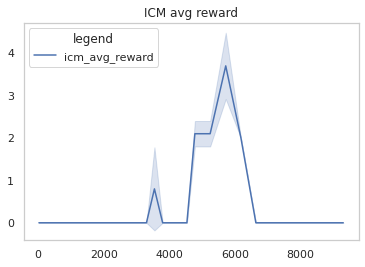

In [ ]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(icm_cum_eps, icm_chkpt_mean_rewards, 'b-', label='icm_avg_reward')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_rewards - icm_chkpt_std_rewards), (icm_chkpt_mean_rewards + icm_chkpt_std_rewards), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("ICM avg reward") 
plt.show()



## ICM avg steps

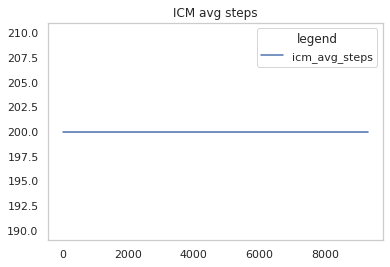

In [ ]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(icm_cum_eps, icm_chkpt_mean_steps, 'b-', label='icm_avg_steps')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_steps - icm_chkpt_std_steps), (icm_chkpt_mean_steps + icm_chkpt_std_steps), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("ICM avg steps") 
plt.show()



## ICM Path

In [ ]:
max_mean_rewards_idx = np.argmax(icm_chkpt_mean_rewards)
#max_mean_rewards_idx = np.argmin(icm_chkpt_mean_steps)

eps_itr = icm_cum_eps[max_mean_rewards_idx]
print(eps_itr)
best_chkpt = icm_df[~(icm_df["eps_cumsum"].where(icm_df['eps_cumsum'] == eps_itr)).isna()]['checkpoint'].values[0]
print("Best checkpoint: ", best_chkpt)

5715.0
Best checkpoint:  240


In [ ]:
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense" 
chkpt_dir = "checkpoint_000" + str(best_chkpt)
chkpt_pth = chkpt_root + "/" + chkpt_dir
chkpt_pth

'/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000240'

In [ ]:
icm_agent.restore(chkpt_pth)

2022-09-27 11:04:58,530	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/dense/checkpoint_000240
2022-09-27 11:04:58,532	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 240, '_timesteps_total': None, '_time_total': 11493.158552408218, '_episodes_total': 5715}


cumulative reward 0.0
total steps: 199
Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/train/dense_reward_rs.wad
Health Bonus locations: [(-704.0, 96.0), (-544.0, 224.0), (-544.0, -128.0), (-608.0, 96.0), (-544.0, 64.0), (-544.0, 128.0), (-544.0, -32.0), (-544.0, 320.0), (-544.0, 384.0), (-800.0, 96.0), (-896.0, 96.0)]
Armor location: [(-544.0, -192.0)]
Sector locations: [(-672.0, -736.0, 32.0, 32.0), (-736.0, -672.0, 160.0, 160.0), (-608.0, -608.0, 192.0, 256.0), (-480.0, -480.0, 256.0, 192.0), (-672.0, -672.0, -256.0, -64.0), (-416.0, -672.0, -256.0, -256.0), (-416.0, -416.0, -64.0, -256.0), (-672.0, -608.0, -64.0, -64.0), (-480.0, -416.0, -64.0, -64.0), (-672.0, -672.0, 0.0, 32.0), (-416.0, -480.0, 0.0, 0.0), (-672.0, -672.0, 160.0, 192.0), (-608.0, -672.0, 0.0, 0.0), (-416.0, -416.0, 192.0, 0.0), (-672.0, -608.0, 192.0, 192.0), (-480.0, -416.0, 192.0, 1

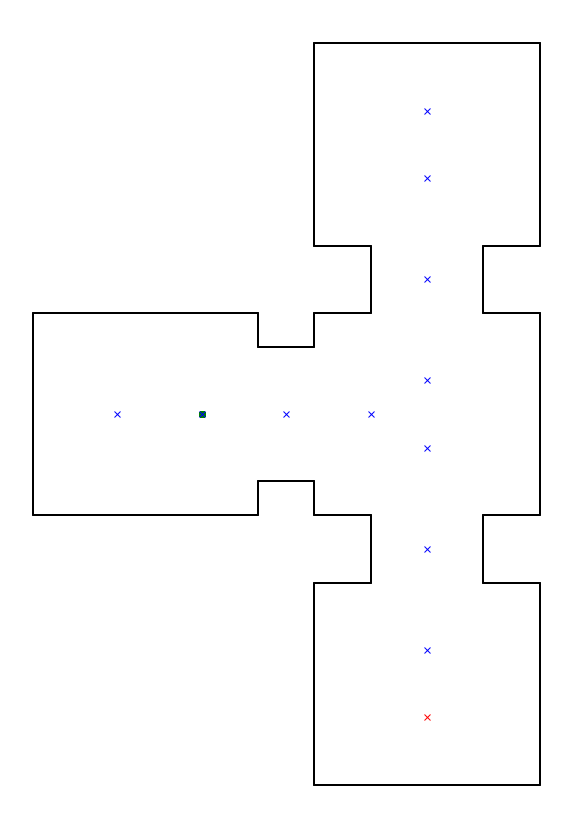

In [ ]:
state = env.reset()
sum_reward = 0
n_step = 200
icm_path = [] 

for step in range(n_step):
    action = icm_agent.compute_action(state)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      icm_path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")

import src.helper_fuctions as helper

sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/train/dense_reward_rs.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, icm_path)


## ICM Goal Accomplishment

In [ ]:
state = env.reset()

#ppo_path = [] 
num_episodes = 100 
goal_reached = 0 

for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    n_step = 200

    for step in range(n_step):
        action = icm_agent.compute_action(state)
        state, reward, done, info = env.step(action)
        eps_reward += reward
      
        if done == 1:
          break 

    if eps_reward >= 10:
        goal_reached += 1
      
    

print(f"Number of time goal reached: {goal_reached} / {num_episodes}")


Number of time goal reached: 6 / 100


# RE3

In [ ]:
class RE3Callbacks(RE3UpdateCallbacks, config["callbacks"]):
  pass

In [ ]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["num_workers"] = 0 

config["log_level"] = "WARN"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['explore'] = False 
config['in_evaluation'] = True
config["framework"] = "tf"
config["seed"] = 12345
config["callbacks"] = RE3Callbacks
config["exploration_config"] = {
    "type": "RE3",
     "embeds_dim": 128,
     "rho": 0.1, # Beta decay factor, used for on-policy algorithm.
     "k_nn": 7, # Number of neighbours to set for K-NN entropy estimation.
     "encoder_net_config": {
         "fcnet_hiddens": [],
         "fcnet_activation": "relu",
     },
     # `reward = r + beta * intrinsic_reward`
     "beta": 0.2,
     # Schedule to use for beta decay, one of constant" or "linear_decay".
     "beta_schedule": 'constant',
     # Specify, which exploration sub-type to use (usually, the algo's "default"
     # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
     "sub_exploration": {
         "type": "StochasticSampling",
     }
}
re3_agent = ppo.PPOTrainer(config, env=select_env)
print("created agent")

/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/new_dense_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


/usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
2022-09-27 10:09:11,540	WARNING util.py:65 -- Install gputil for GPU system monitoring.


created agent


In [ ]:
env = gym.make('VizDoomVeryDenseReward-v0')

config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/new_dense_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


In [ ]:

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense" 

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))


re3_chkpt_mean_rewards = np.array([]) 
re3_chkpt_std_rewards = np.array([]) 
re3_chkpt_mean_steps = np.array([]) 
re3_chkpt_std_steps = np.array([]) 


for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  re3_agent.restore(chkpt_pth)

  num_episodes = 10
  total_reward = []
  total_steps = [] 
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    eps_steps = 0 
    n_step = 200

    for step in range(n_step):
          action = re3_agent.compute_action(state)
          state, reward, done, info = env.step(action)
          eps_reward += reward

          #if episode ends early
          if done == 1:
              total_reward.append(eps_reward)
              total_steps.append(step+1)
              state = env.reset()
              break

    #if episode timeout
    if done == 0:
      total_reward.append(eps_reward)
      total_steps.append(n_step)

  #get mean and std over all episodes
  re3_chkpt_mean_rewards = np.append(re3_chkpt_mean_rewards, np.mean(total_reward) )
  re3_chkpt_std_rewards = np.append(re3_chkpt_std_rewards, np.std(total_reward))
  re3_chkpt_mean_steps = np.append(re3_chkpt_mean_steps, np.mean(total_steps))
  re3_chkpt_std_steps = np.append(re3_chkpt_std_steps, np.std(total_steps))



In [ ]:
results_pth = chkpt_root + '/' + 'result.csv'
re3_df = pd.read_csv(results_pth) 
re3_df['eps_cumsum'] = re3_df['episodes_this_iter'].cumsum()
re3_df = re3_df[['checkpoint', 'eps_cumsum']]
re3_df.checkpoint = re3_df['checkpoint'].astype(int)
re3_df.head()

,checkpoint,eps_cumsum
0,1,20.0
1,2,40.0
2,3,60.0
3,4,80.0
4,5,102.0


In [ ]:
re3_cum_eps = [] 
for chkpt in checkpoints:
  chkpt_int = int(chkpt.split('_')[-1])
  eps_num = re3_df[~(re3_df['eps_cumsum'].where(re3_df['checkpoint'] == chkpt_int)).isna()].eps_cumsum.values[0]
  re3_cum_eps.append(eps_num)

print(f"Total episodes: {re3_cum_eps}")
print(f"Mean reward: {re3_chkpt_mean_rewards}")
print(f"Std reward: {re3_chkpt_std_rewards}")
print(f"Mean steps: {re3_chkpt_mean_steps}")
print(f"Std steps: {re3_chkpt_std_steps}")

#check length of lists are the same 
assert len(re3_cum_eps) == len(re3_chkpt_mean_rewards)
assert len(re3_cum_eps) == len(re3_chkpt_mean_steps)

Total episodes: [20.0, 214.0, 460.0, 703.0, 961.0, 1245.0, 1539.0, 1821.0, 2122.0, 2431.0, 2753.0, 3076.0, 3400.0, 3720.0, 4077.0, 4445.0, 4826.0, 5178.0, 5536.0, 5904.0, 6243.0, 6949.0, 7713.0, 8639.0, 9740.0, 11129.0, 12653.0, 14209.0, 15864.0, 17505.0, 19082.0]
Mean reward: [ 0.   0.   3.   6.7 14.1 15.8  4.   7.   6.   5.   5.   7.1 10.5  4.
  4.   7.2  4.8 15.   5.   9.9  5.  15.  14.  14.  14.  15.  15.  15.
 15.  15.  15. ]
Std reward: [0.         0.         0.         4.53982379 2.7        4.4
 0.         0.         0.         0.         0.         3.3
 5.57225269 0.         0.         3.6        0.9797959  0.
 0.         4.84664833 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Mean steps: [200.  200.  200.  172.5  56.2 149.4 200.  200.  200.  200.  200.  189.5
 171.3 200.  200.  192.2 200.  103.4 200.  145.6 200.   36.6  38.   25.
  28.6  27.6  26.   26.   26.   26.   26. ]
Std steps: [ 0.          0.          0.   

## RE3 avg reward

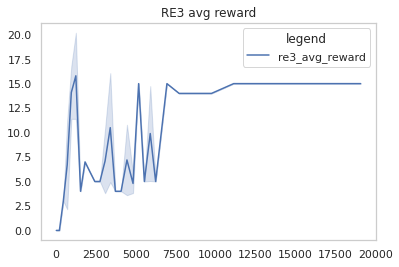

In [ ]:
# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(re3_cum_eps, re3_chkpt_mean_rewards, 'b-', label='re3_avg_reward')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_rewards - re3_chkpt_std_rewards), (re3_chkpt_mean_rewards + re3_chkpt_std_rewards), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("RE3 avg reward") 
plt.show()



## RE3 avg steps

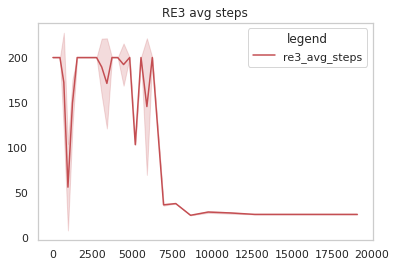

In [ ]:
# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(re3_cum_eps, re3_chkpt_mean_steps, 'r-', label='re3_avg_steps')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_steps - re3_chkpt_std_steps), (re3_chkpt_mean_steps + re3_chkpt_std_steps), color='r', alpha=0.2) 

plt.legend(title='legend')
plt.title("RE3 avg steps") 
plt.show()

## RE3 Path

In [ ]:
max_mean_rewards_idx = np.argmax(re3_chkpt_mean_rewards)
#max_mean_rewards_idx = np.argmin(re3_chkpt_mean_steps)
eps_itr = re3_cum_eps[max_mean_rewards_idx]
print(eps_itr)
best_chkpt = re3_df[~(re3_df["eps_cumsum"].where(re3_df['eps_cumsum'] == eps_itr)).isna()]['checkpoint'].values[-1]
print("Best checkpoint: ", best_chkpt)

1245.0
Best checkpoint:  50


In [ ]:
chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense" 
chkpt_dir = "checkpoint_0000" + str(best_chkpt)
chkpt_pth = chkpt_root + "/" + chkpt_dir
chkpt_pth

'/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000050'

In [ ]:
re3_agent.restore(chkpt_pth)

2022-09-27 11:11:53,271	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/dense/checkpoint_000050
2022-09-27 11:11:53,274	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 3025.5028047561646, '_episodes_total': 1245}


cumulative reward 14.0
total steps: 24
Config file path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
Scenario path: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/train/dense_reward_rs.wad
Health Bonus locations: [(-704.0, 96.0), (-544.0, 224.0), (-544.0, -128.0), (-608.0, 96.0), (-544.0, 64.0), (-544.0, 128.0), (-544.0, -32.0), (-544.0, 320.0), (-544.0, 384.0), (-800.0, 96.0), (-896.0, 96.0)]
Armor location: [(-544.0, -192.0)]
Sector locations: [(-672.0, -736.0, 32.0, 32.0), (-736.0, -672.0, 160.0, 160.0), (-608.0, -608.0, 192.0, 256.0), (-480.0, -480.0, 256.0, 192.0), (-672.0, -672.0, -256.0, -64.0), (-416.0, -672.0, -256.0, -256.0), (-416.0, -416.0, -64.0, -256.0), (-672.0, -608.0, -64.0, -64.0), (-480.0, -416.0, -64.0, -64.0), (-672.0, -672.0, 0.0, 32.0), (-416.0, -480.0, 0.0, 0.0), (-672.0, -672.0, 160.0, 192.0), (-608.0, -672.0, 0.0, 0.0), (-416.0, -416.0, 192.0, 0.0), (-672.0, -608.0, 192.0, 192.0), (-480.0, -416.0, 192.0, 1

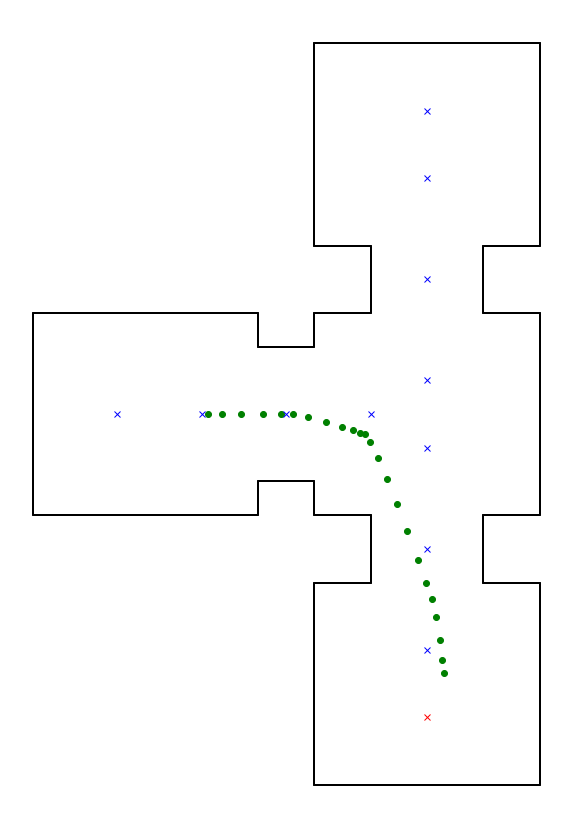

In [ ]:
state = env.reset()
sum_reward = 0
n_step = 200
re3_path = [] 

for step in range(n_step):
    action = re3_agent.compute_action(state)
    state, reward, done, info = env.step(action)
    sum_reward += reward
    
    if len(info) > 0:
      re3_path.append((info["X"], info["Y"]))

    #env.render()

    if done == 1:
        # report at the end of each episode
        print("cumulative reward", sum_reward)
        print(f"total steps: {step}")
        state = env.reset()
        sum_reward = 0
        break

if done == 0:
  print("cumulative reward", sum_reward)
  print(f"total steps: {step}")


sectors, health_pos, armor_pos = helper.get_env_layout(config = "custom/very_dense_reward.cfg",
                                                       scenario = "custom/train/dense_reward_rs.wad" )
helper.plot_layout(sectors, health_pos, armor_pos, re3_path)


## RE3 Goal Accomplishment

In [ ]:
state = env.reset()

#ppo_path = [] 
num_episodes = 100 
goal_reached = 0 

for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    n_step = 200

    for step in range(n_step):
        action = re3_agent.compute_action(state)
        state, reward, done, info = env.step(action)
        eps_reward += reward
      
        if done == 1:
          break 

    if eps_reward >= 10:
        goal_reached += 1
      
    

print(f"Number of time goal reached: {goal_reached} / {num_episodes}")


Number of time goal reached: 75 / 100


# All graphs

## Plot all paths

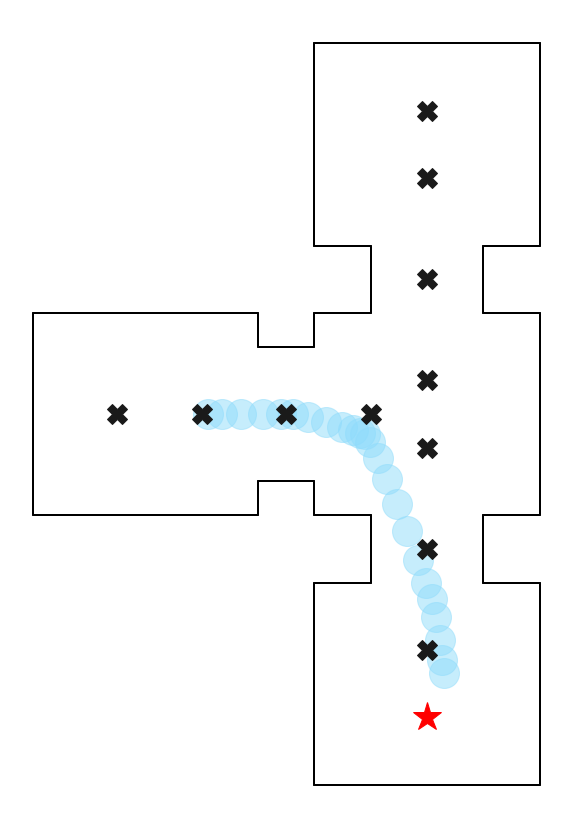

In [ ]:
plt.rcParams["figure.figsize"] = (10,15)

for sector in sectors:
        plt.plot([sector[0], sector[1]], [sector[2], sector[3]], color='black', linewidth=2)

# plot path taken
#for pos in ppo_path:
#    plt.plot(pos[0], pos[1], color='#B5E7B5', marker='o', markersize = 30, alpha = 0.5)
#for pos in icm_path:
#    plt.plot(pos[0], pos[1], color='#F08880', marker='o', markersize = 30, alpha = 0.5)
for pos in re3_path:
    plt.plot(pos[0], pos[1], color='#8FDCFB', marker='o', markersize=30, alpha = 0.5)

#'#2E75B6'
    

# plot positions of health bonus and armor:
for pos in health_pos:
    plt.plot(pos[0], pos[1], color='k', marker='X', markersize = 20)
for pos in armor_pos:
    plt.plot(pos[0], pos[1], color='red', marker='*', markersize = 30)

plt.axis("off")
plt.show()


## Average Reward

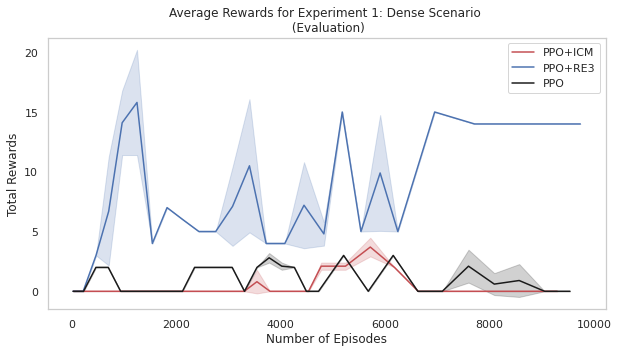

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
 
#ICM
plt.plot(icm_cum_eps, icm_chkpt_mean_rewards, 'r-', label='PPO+ICM')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_rewards - icm_chkpt_std_rewards), (icm_chkpt_mean_rewards + icm_chkpt_std_rewards), color='r', alpha=0.2) 
#RE3
plt.plot(re3_cum_eps[:25], re3_chkpt_mean_rewards[:25], 'b-', label='PPO+RE3')
plt.fill_between(re3_cum_eps[:25], (re3_chkpt_mean_rewards - re3_chkpt_std_rewards)[:25], (re3_chkpt_mean_rewards + re3_chkpt_std_rewards)[:25], color='b', alpha=0.2) 
#PPO 
plt.plot(ppo_cum_eps, ppo_chkpt_mean_rewards, 'k-', label='PPO')
plt.fill_between(ppo_cum_eps, ppo_chkpt_mean_rewards - ppo_chkpt_std_rewards, ppo_chkpt_mean_rewards + ppo_chkpt_std_rewards, color='k', alpha=0.2) 


plt.legend()
plt.title("Average Rewards for Experiment 1: Dense Scenario \n (Evaluation)") 
plt.xlabel('Number of Episodes') 
plt.ylabel('Total Rewards') 
plt.show()


## Average Steps

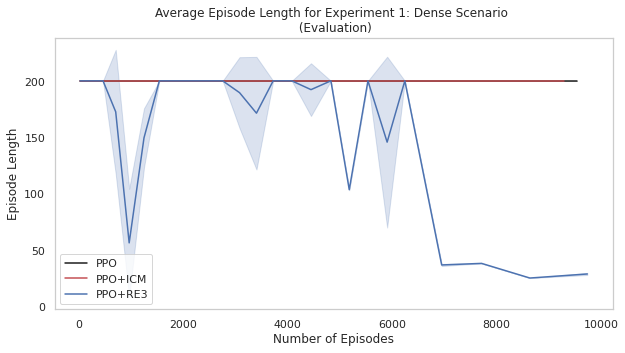

In [ ]:
#PPO
plt.plot(ppo_cum_eps, ppo_chkpt_mean_steps, 'k-', label='PPO')
plt.fill_between(ppo_cum_eps, (ppo_chkpt_mean_steps - ppo_chkpt_std_steps), (ppo_chkpt_mean_steps + ppo_chkpt_std_steps), color='k', alpha=0.2) 

#ICM
plt.plot(icm_cum_eps, icm_chkpt_mean_steps, 'r-', label='PPO+ICM')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_steps - icm_chkpt_std_steps), (icm_chkpt_mean_steps + icm_chkpt_std_steps), color='r', alpha=0.2) 

#RE3
plt.plot(re3_cum_eps[:25], re3_chkpt_mean_steps[:25], 'b-', label='PPO+RE3')
plt.fill_between(re3_cum_eps[:25], (re3_chkpt_mean_steps - re3_chkpt_std_steps)[:25], (re3_chkpt_mean_steps + re3_chkpt_std_steps)[:25], color='b', alpha=0.2) 

plt.legend()
plt.title("Average Episode Length for Experiment 1: Dense Scenario \n (Evaluation)") 
plt.xlabel('Number of Episodes') 
plt.ylabel('Episode Length') 
plt.show()

# Save results file

In [ ]:
from pathlib import Path 
root = "/content/drive/MyDrive/GitHub/INM363-Project/results" 
cols = ["episodes", "mean_reward", "std_reward", "mean_steps", "std_steps"]

## PPO

In [ ]:
fname = "/E1a_ppo_dense.csv"

df_ppo = pd.DataFrame(columns = cols)
df_ppo["episodes"] = ppo_cum_eps
df_ppo["mean_reward"] = ppo_chkpt_mean_rewards
df_ppo["std_reward"] = ppo_chkpt_std_rewards
df_ppo["mean_steps"] = ppo_chkpt_mean_steps
df_ppo["std_steps"] = ppo_chkpt_std_steps

fpath = Path(root + fname)
df_ppo.to_csv(fpath)
print(f"Saved results file to {fpath.as_posix()}")

df_ppo.head()

Saved results file to /content/drive/MyDrive/GitHub/INM363-Project/results/E1a_ppo_dense.csv


,episodes,mean_reward,std_reward,mean_steps,std_steps
0,20.0,0.0,0.0,200.0,0.0
1,221.0,0.0,0.0,200.0,0.0
2,458.0,2.0,0.0,200.0,0.0
3,694.0,2.0,0.0,200.0,0.0
4,931.0,0.0,0.0,200.0,0.0


## ICM

In [ ]:
fname = "/E1a_icm_dense.csv"

df_icm = pd.DataFrame(columns = cols)
df_icm["episodes"] = icm_cum_eps
df_icm["mean_reward"] = icm_chkpt_mean_rewards
df_icm["std_reward"] = icm_chkpt_std_rewards
df_icm["mean_steps"] = icm_chkpt_mean_steps
df_icm["std_steps"] = icm_chkpt_std_steps

fpath = Path(root + fname)
df_icm.to_csv(fpath)
print(f"Saved results file to {fpath.as_posix()}")

df_icm.head()

Saved results file to /content/drive/MyDrive/GitHub/INM363-Project/results/E1a_icm_dense.csv


,episodes,mean_reward,std_reward,mean_steps,std_steps
0,24.0,0.0,0.0,200.0,0.0
1,120.0,0.0,0.0,200.0,0.0
2,352.0,0.0,0.0,200.0,0.0
3,578.0,0.0,0.0,200.0,0.0
4,803.0,0.0,0.0,200.0,0.0


## RE3

In [ ]:
fname = "/E1a_re3_dense.csv"

df_re3 = pd.DataFrame(columns = cols)
df_re3["episodes"] = re3_cum_eps
df_re3["mean_reward"] = re3_chkpt_mean_rewards
df_re3["std_reward"] = re3_chkpt_std_rewards
df_re3["mean_steps"] = re3_chkpt_mean_steps
df_re3["std_steps"] = re3_chkpt_std_steps

fpath = Path(root + fname)
df_re3.to_csv(fpath)
print(f"Saved results file to {fpath.as_posix()}")

df_re3.head()

Saved results file to /content/drive/MyDrive/GitHub/INM363-Project/results/E1a_re3_dense.csv


,episodes,mean_reward,std_reward,mean_steps,std_steps
0,20.0,0.0,0.000000,200.0,0.000000
1,214.0,0.0,0.000000,200.0,0.000000
2,460.0,3.0,0.000000,200.0,0.000000
3,703.0,6.7,4.539824,172.5,55.000455
4,961.0,14.1,2.700000,56.2,47.991249
